In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score, roc_curve, roc_auc_score)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [5]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [6]:
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Dataset shape: (8807, 12)
Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']


In [7]:
df['director'].fillna('Unknown', inplace=True)
df['cast'].fillna('Unknown', inplace=True)
df['country'].fillna('Unknown', inplace=True)
df['rating'].fillna(df['rating'].mode()[0], inplace=True)
df['date_added'].fillna('Unknown', inplace=True)
df['duration'].fillna('Unknown', inplace=True)

In [8]:
df['date_added_parsed'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added_parsed'].dt.year
df['month_added'] = df['date_added_parsed'].dt.month
df['day_of_week_added'] = df['date_added_parsed'].dt.dayofweek

In [9]:
df['year_added'].fillna(df['year_added'].median(), inplace=True)
df['month_added'].fillna(df['month_added'].median(), inplace=True)
df['day_of_week_added'].fillna(0, inplace=True)
df['duration_value'] = df['duration'].str.extract('(\d+)').astype(float)
df['duration_value'].fillna(df['duration_value'].median(), inplace=True)

df['is_movie'] = (df['type'] == 'Movie').astype(int)

df['num_countries'] = df['country'].apply(lambda x: len(str(x).split(',')) if x != 'Unknown' else 0)
df['num_genres'] = df['listed_in'].apply(lambda x: len(str(x).split(',')) if pd.notna(x) else 0)
df['description_length'] = df['description'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)
df['title_length'] = df['title'].apply(lambda x: len(str(x)) if pd.notna(x) else 0)

In [10]:
df['content_age'] = 2021 - df['release_year']

df['release_decade'] = (df['release_year'] // 10) * 10

print(f"✓ Feature engineering completed")
print(f"New features: {len(df.columns)} columns")

df.to_csv('netflix_processed.csv', index=False)
print("✓ Saved: netflix_processed.csv")

✓ Feature engineering completed
New features: 24 columns
✓ Saved: netflix_processed.csv


In [11]:
numerical_features = [
    'release_year', 'year_added', 'month_added', 'day_of_week_added',
    'duration_value', 'num_countries', 'num_genres', 'description_length',
    'title_length', 'content_age'
]

X_numerical = df[numerical_features].fillna(0)

label_encoder = LabelEncoder()
y_type = label_encoder.fit_transform(df['type'])

y_rating = label_encoder.fit_transform(df['rating'])

X = X_numerical
y = y_type

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features: {len(numerical_features)}")
print(f"Target classes: {label_encoder.classes_}")

Training samples: 7045
Test samples: 1762
Features: 10
Target classes: ['66 min' '74 min' '84 min' 'G' 'NC-17' 'NR' 'PG' 'PG-13' 'R' 'TV-14'
 'TV-G' 'TV-MA' 'TV-PG' 'TV-Y' 'TV-Y7' 'TV-Y7-FV' 'UR']


In [14]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
    'Naive Bayes': MultinomialNB()
}
results = {}
for name,model in models.items():
    if name == 'Naive Bayes':
        X_train_model = X_train + abs(X_train.min().min()) + 1
        X_test_model = X_test + abs(X_train.min().min()) + 1
    else:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    model.fit(X_train_model, y_train)
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1] if hasattr(model, 'predict_proba') else None
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'model': model
    }
    print(f"{name}: Accuracy={accuracy:.3f}, F1={f1:.3f}")

Random Forest: Accuracy=0.999, F1=0.999
Gradient Boosting: Accuracy=0.999, F1=0.999
Logistic Regression: Accuracy=1.000, F1=1.000
SVM: Accuracy=0.998, F1=0.998
KNN: Accuracy=0.986, F1=0.986
Decision Tree: Accuracy=0.999, F1=0.999
AdaBoost: Accuracy=0.999, F1=0.999
Naive Bayes: Accuracy=0.994, F1=0.994


In [15]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1'] for m in results]
})
results_df.to_csv('model_performance_netflix.csv', index=False)
print("\nSaved: model_performance_netflix.csv")


Saved: model_performance_netflix.csv


In [16]:
import os
os.makedirs('netflix_visualizations', exist_ok=True)

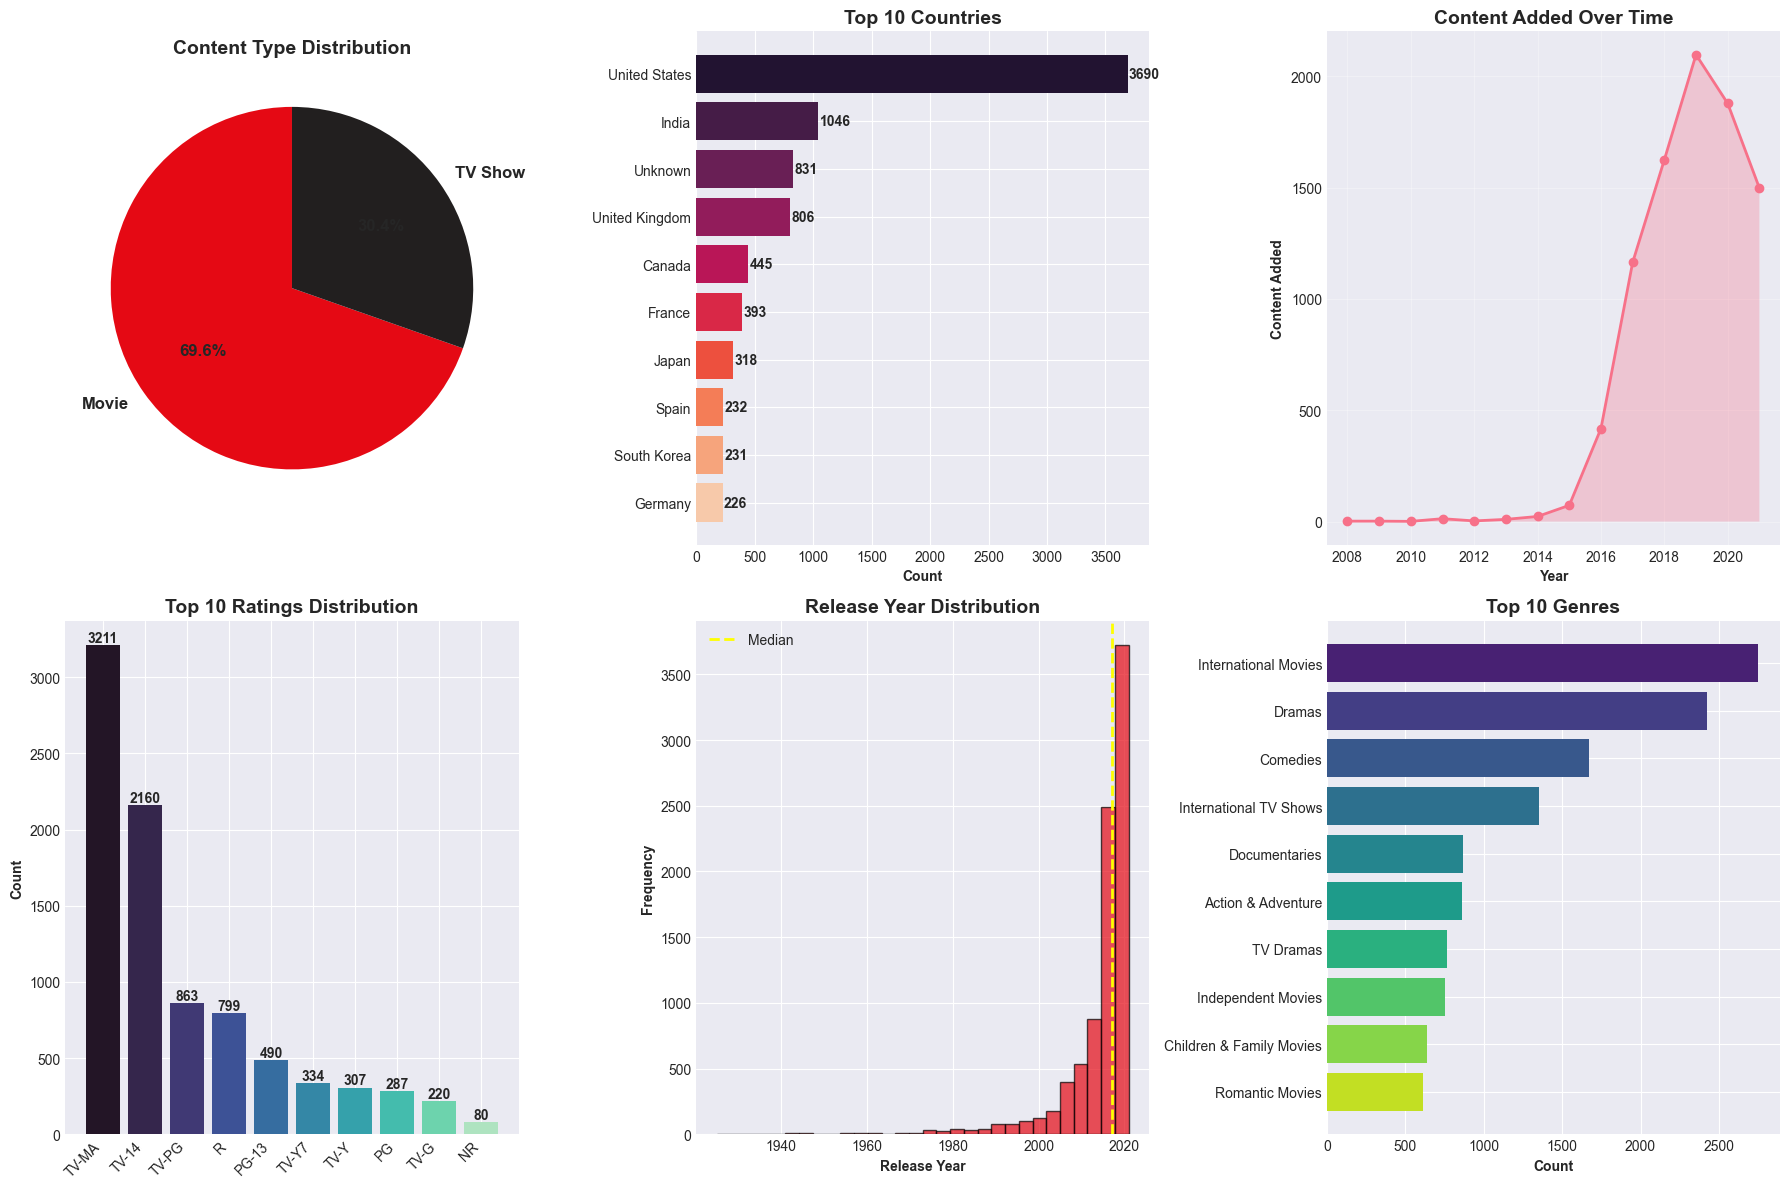

✓ Saved: 01_data_overview.png


In [17]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

ax = axes[0, 0]
type_counts = df['type'].value_counts()
colors_pie = ['#E50914', '#221f1f']
wedges, texts, autotexts = ax.pie(type_counts, labels=type_counts.index,
                                    autopct='%1.1f%%', colors=colors_pie,
                                    startangle=90, textprops={'fontweight': 'bold', 'fontsize': 12})
ax.set_title('Content Type Distribution', fontsize=14, fontweight='bold')

ax = axes[0, 1]
country_counts = df['country'].str.split(',').explode().str.strip().value_counts().head(10)
bars = ax.barh(range(len(country_counts)), country_counts.values,
               color=sns.color_palette("rocket", len(country_counts)))
ax.set_yticks(range(len(country_counts)))
ax.set_yticklabels(country_counts.index)
ax.set_xlabel('Count', fontweight='bold')
ax.set_title('Top 10 Countries', fontsize=14, fontweight='bold')
ax.invert_yaxis()
for i, v in enumerate(country_counts.values):
    ax.text(v + 10, i, str(v), va='center', fontweight='bold')

ax = axes[0, 2]
yearly_counts = df['year_added'].value_counts().sort_index()
ax.plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, markersize=6)
ax.fill_between(yearly_counts.index, yearly_counts.values, alpha=0.3)
ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Content Added', fontweight='bold')
ax.set_title('Content Added Over Time', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

ax = axes[1, 0]
rating_counts = df['rating'].value_counts().head(10)
bars = ax.bar(range(len(rating_counts)), rating_counts.values,
              color=sns.color_palette("mako", len(rating_counts)))
ax.set_xticks(range(len(rating_counts)))
ax.set_xticklabels(rating_counts.index, rotation=45, ha='right')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Top 10 Ratings Distribution', fontsize=14, fontweight='bold')
for i, v in enumerate(rating_counts.values):
    ax.text(i, v + 20, str(v), ha='center', fontweight='bold')

ax = axes[1, 1]
ax.hist(df['release_year'], bins=30, color='#E50914', alpha=0.7, edgecolor='black')
ax.set_xlabel('Release Year', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Release Year Distribution', fontsize=14, fontweight='bold')
ax.axvline(df['release_year'].median(), color='yellow', linestyle='--', linewidth=2, label='Median')
ax.legend()

ax = axes[1, 2]
genres = df['listed_in'].str.split(',').explode().str.strip().value_counts().head(10)
bars = ax.barh(range(len(genres)), genres.values,
               color=sns.color_palette("viridis", len(genres)))
ax.set_yticks(range(len(genres)))
ax.set_yticklabels(genres.index)
ax.set_xlabel('Count', fontweight='bold')
ax.set_title('Top 10 Genres', fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('netflix_visualizations/01_data_overview.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 01_data_overview.png")

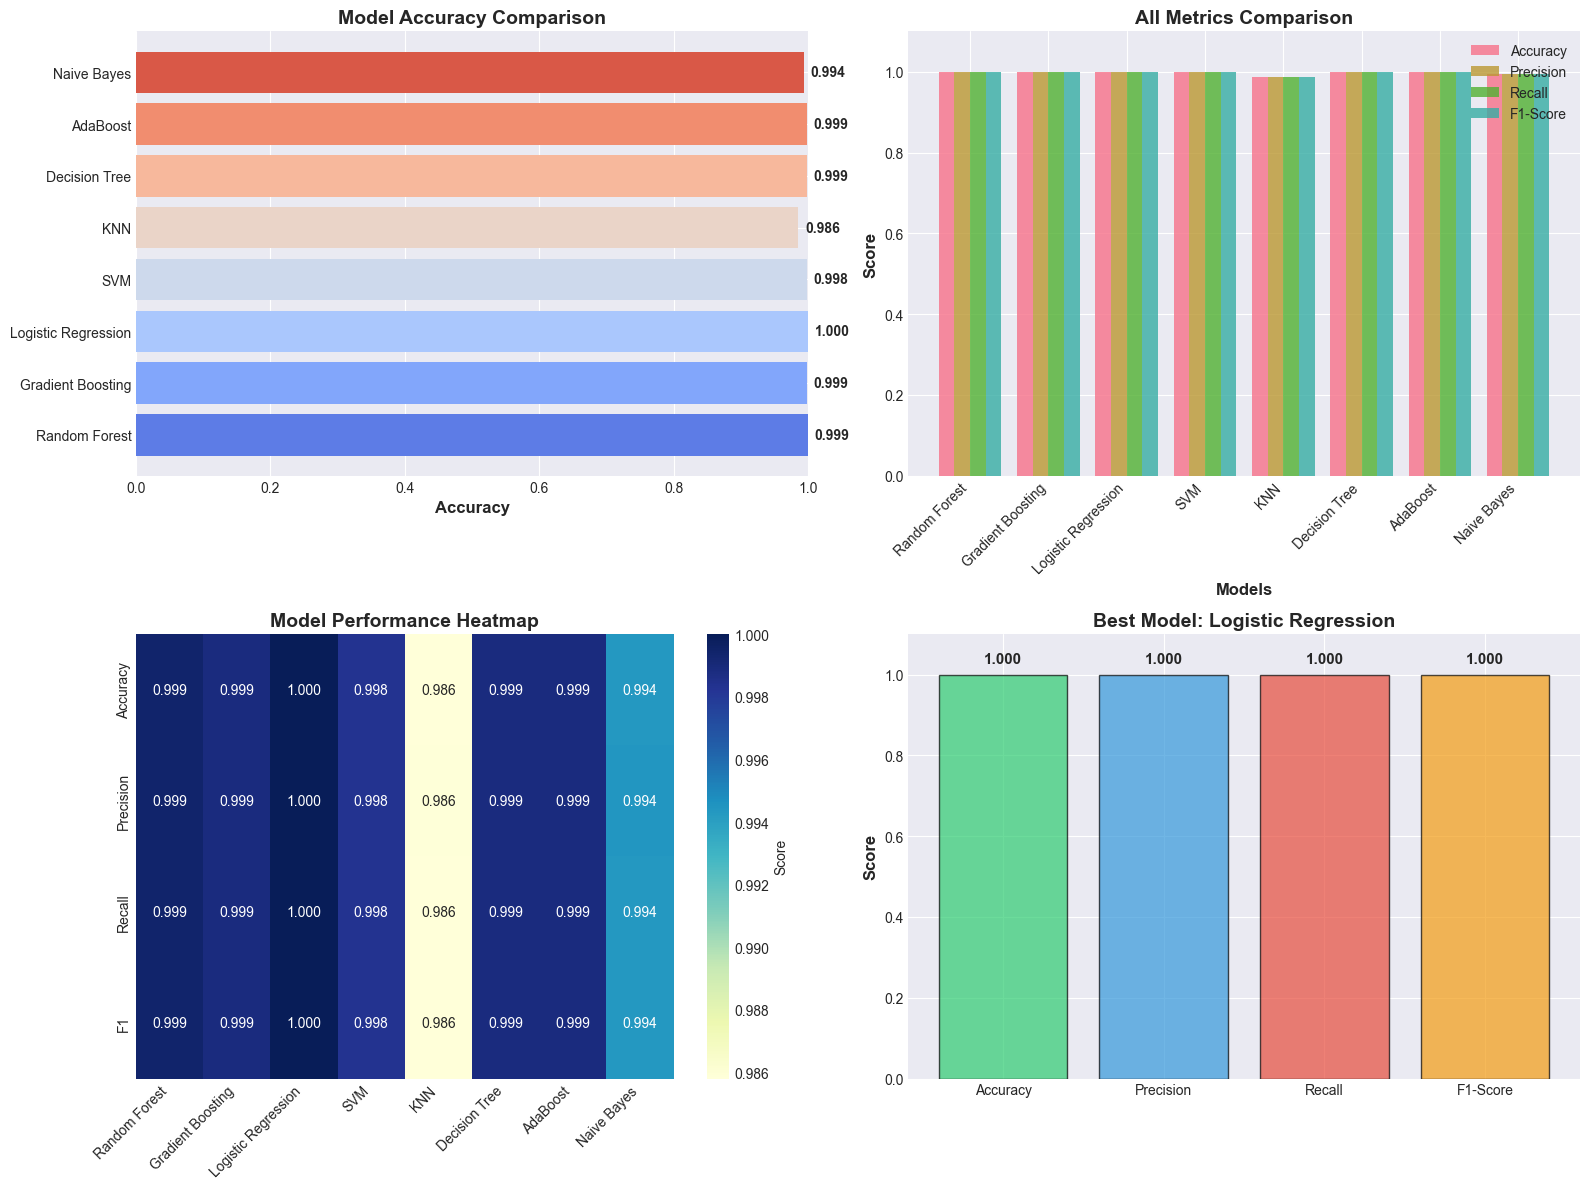

✓ Saved: 02_model_performance.png


In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
bars = ax.barh(model_names, accuracies, color=sns.color_palette("coolwarm", len(model_names)))
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1)
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax.text(acc + 0.01, i, f'{acc:.3f}', va='center', fontsize=10, fontweight='bold')

ax = axes[0, 1]
x = np.arange(len(model_names))
width = 0.2
ax.bar(x - 1.5*width, [results[m]['accuracy'] for m in model_names], width, label='Accuracy', alpha=0.8)
ax.bar(x - 0.5*width, [results[m]['precision'] for m in model_names], width, label='Precision', alpha=0.8)
ax.bar(x + 0.5*width, [results[m]['recall'] for m in model_names], width, label='Recall', alpha=0.8)
ax.bar(x + 1.5*width, [results[m]['f1'] for m in model_names], width, label='F1-Score', alpha=0.8)
ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.1)

ax = axes[1, 0]
metrics_matrix = np.array([
    [results[m]['accuracy'] for m in model_names],
    [results[m]['precision'] for m in model_names],
    [results[m]['recall'] for m in model_names],
    [results[m]['f1'] for m in model_names]
])
sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='YlGnBu',
            xticklabels=model_names, yticklabels=['Accuracy', 'Precision', 'Recall', 'F1'],
            cbar_kws={'label': 'Score'}, ax=ax)
ax.set_title('Model Performance Heatmap', fontsize=14, fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax = axes[1, 1]
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_metrics = [
    results[best_model_name]['accuracy'],
    results[best_model_name]['precision'],
    results[best_model_name]['recall'],
    results[best_model_name]['f1']
]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_best = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
bars = ax.bar(metric_names, best_metrics, color=colors_best, alpha=0.7, edgecolor='black')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title(f'Best Model: {best_model_name}', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.1)
for bar, metric in zip(bars, best_metrics):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{metric:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('netflix_visualizations/02_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 02_model_performance.png")

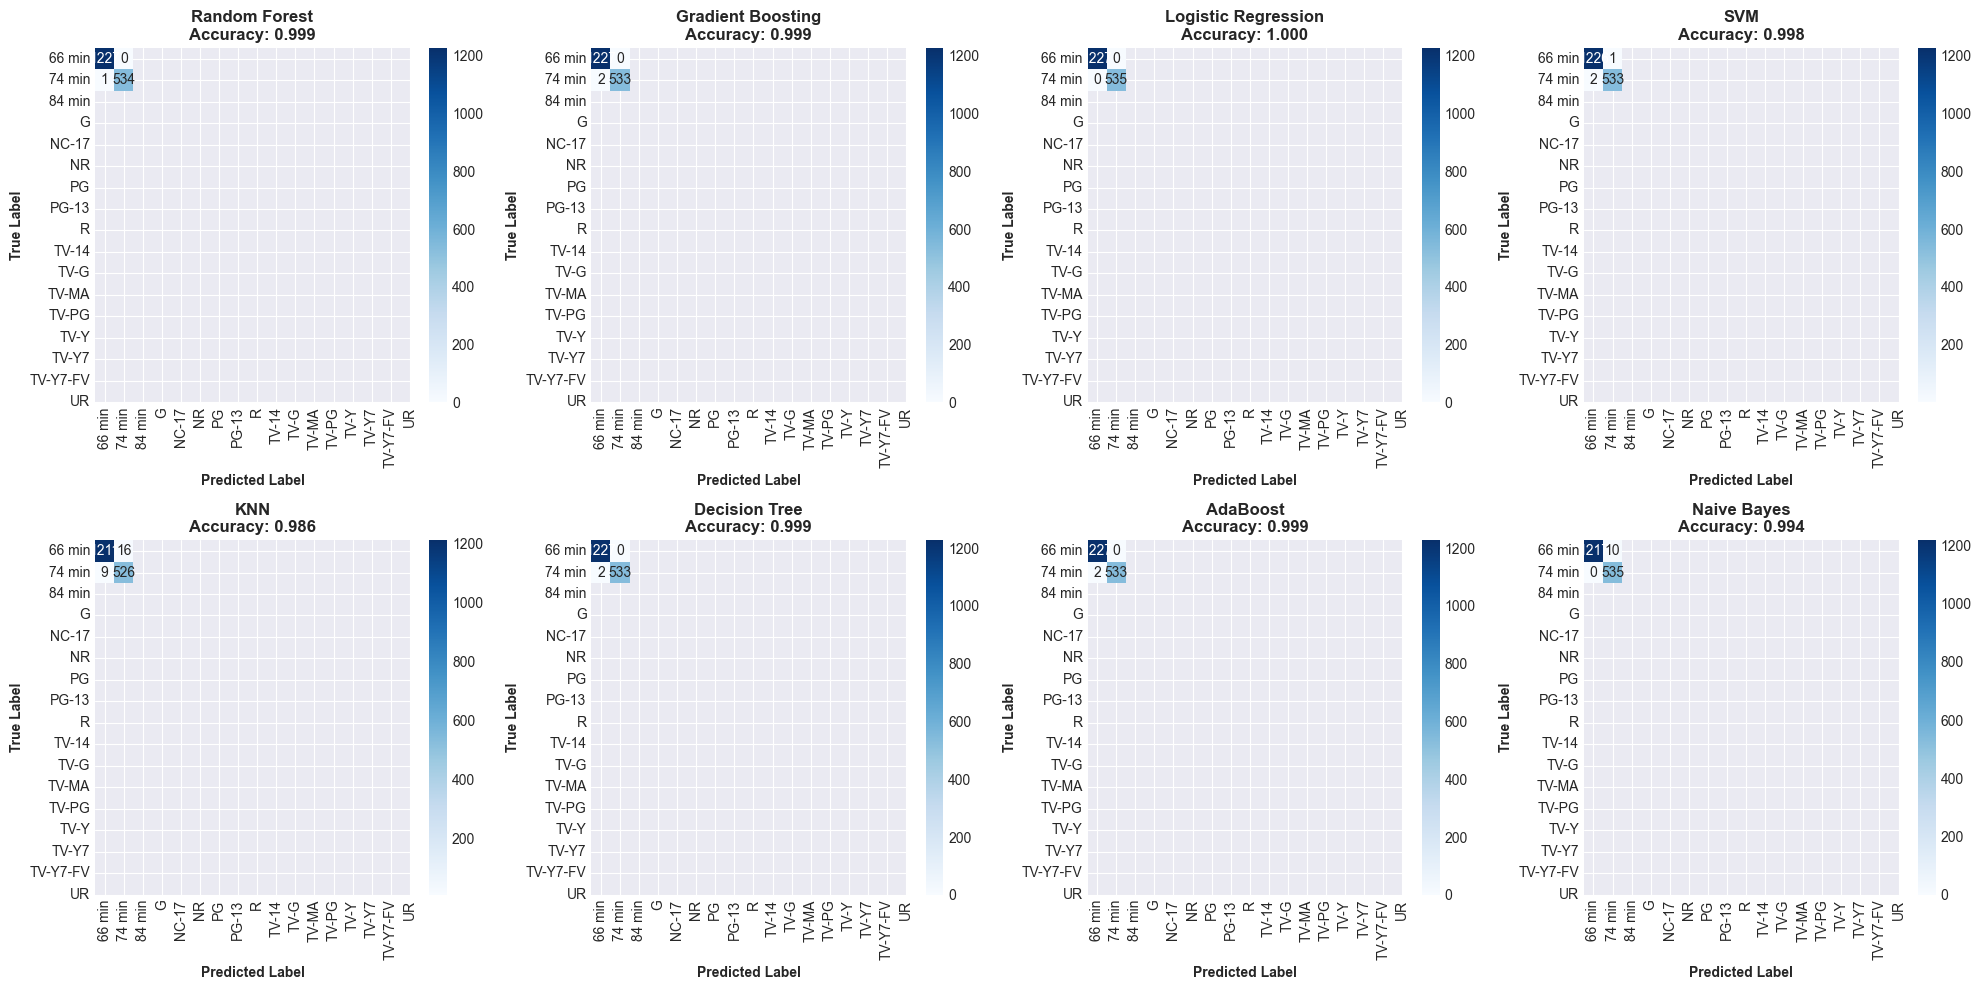

✓ Saved: 03_confusion_matrices.png


In [19]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}', fontweight='bold')
    axes[idx].set_ylabel('True Label', fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontweight='bold')

plt.tight_layout()
plt.savefig('netflix_visualizations/03_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 03_confusion_matrices.png")

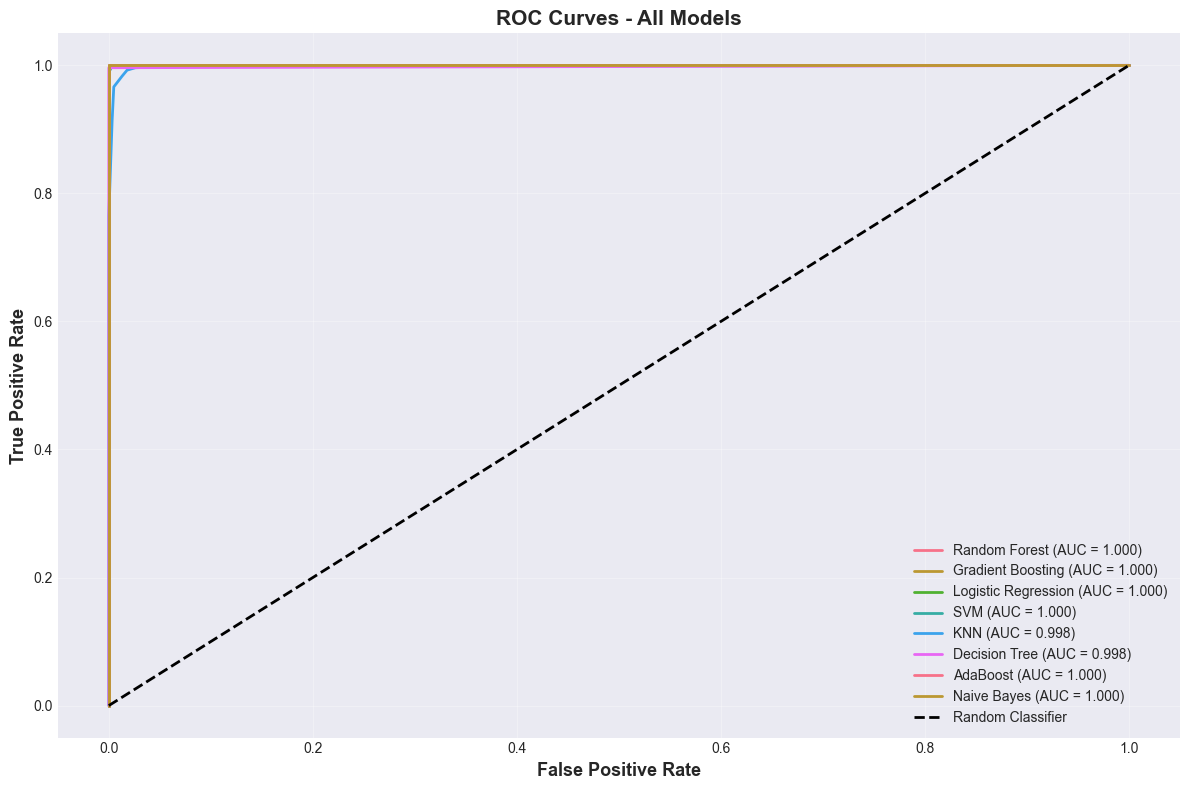

✓ Saved: 04_roc_curves.png


In [20]:
plt.figure(figsize=(12, 8))

for name, result in results.items():
    if result['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
        auc = roc_auc_score(y_test, result['probabilities'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves - All Models', fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('netflix_visualizations/04_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 04_roc_curves.png")

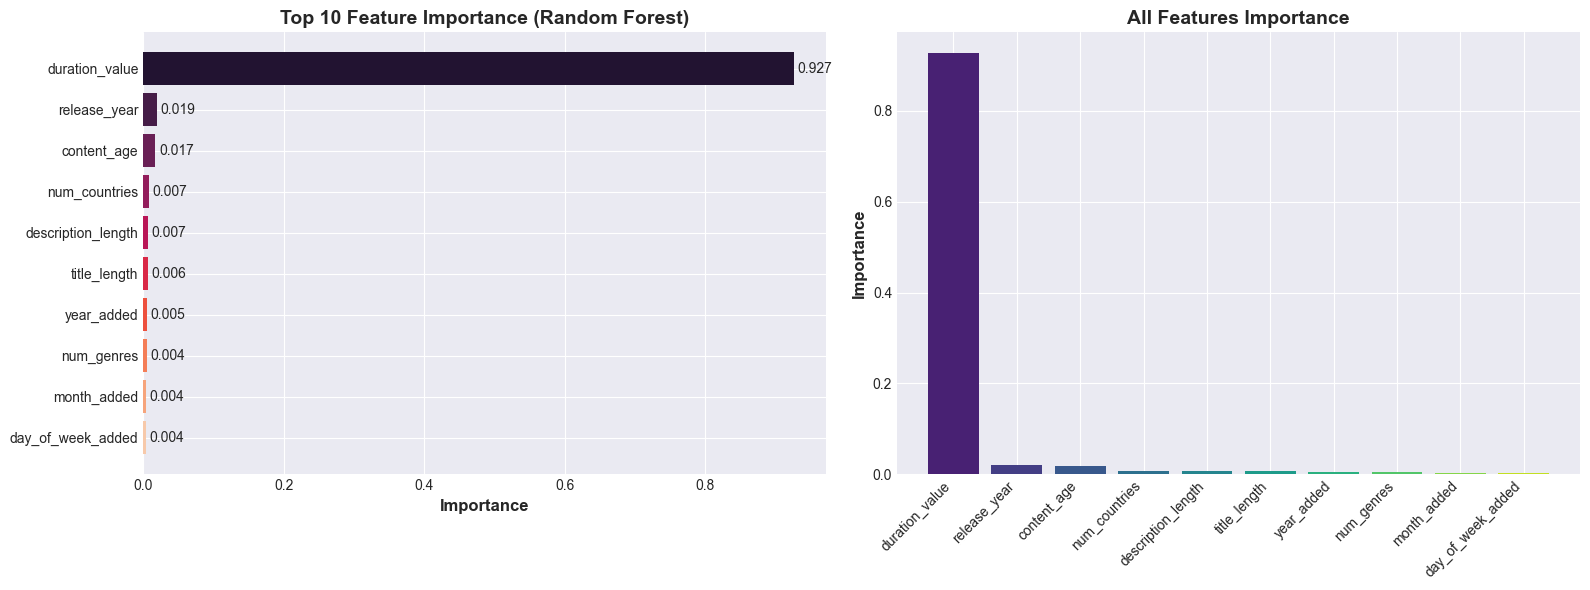

✓ Saved: 05_feature_importance.png


In [21]:
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': numerical_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
top_features = feature_importance.head(10)
bars = ax.barh(top_features['feature'], top_features['importance'],
               color=sns.color_palette("rocket", len(top_features)))
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
for i, (feat, imp) in enumerate(zip(top_features['feature'], top_features['importance'])):
    ax.text(imp + 0.005, i, f'{imp:.3f}', va='center', fontsize=10)

ax = axes[1]
bars = ax.bar(range(len(feature_importance)), feature_importance['importance'],
              color=sns.color_palette("viridis", len(feature_importance)))
ax.set_xticks(range(len(feature_importance)))
ax.set_xticklabels(feature_importance['feature'], rotation=45, ha='right')
ax.set_ylabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('All Features Importance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('netflix_visualizations/05_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 05_feature_importance.png")


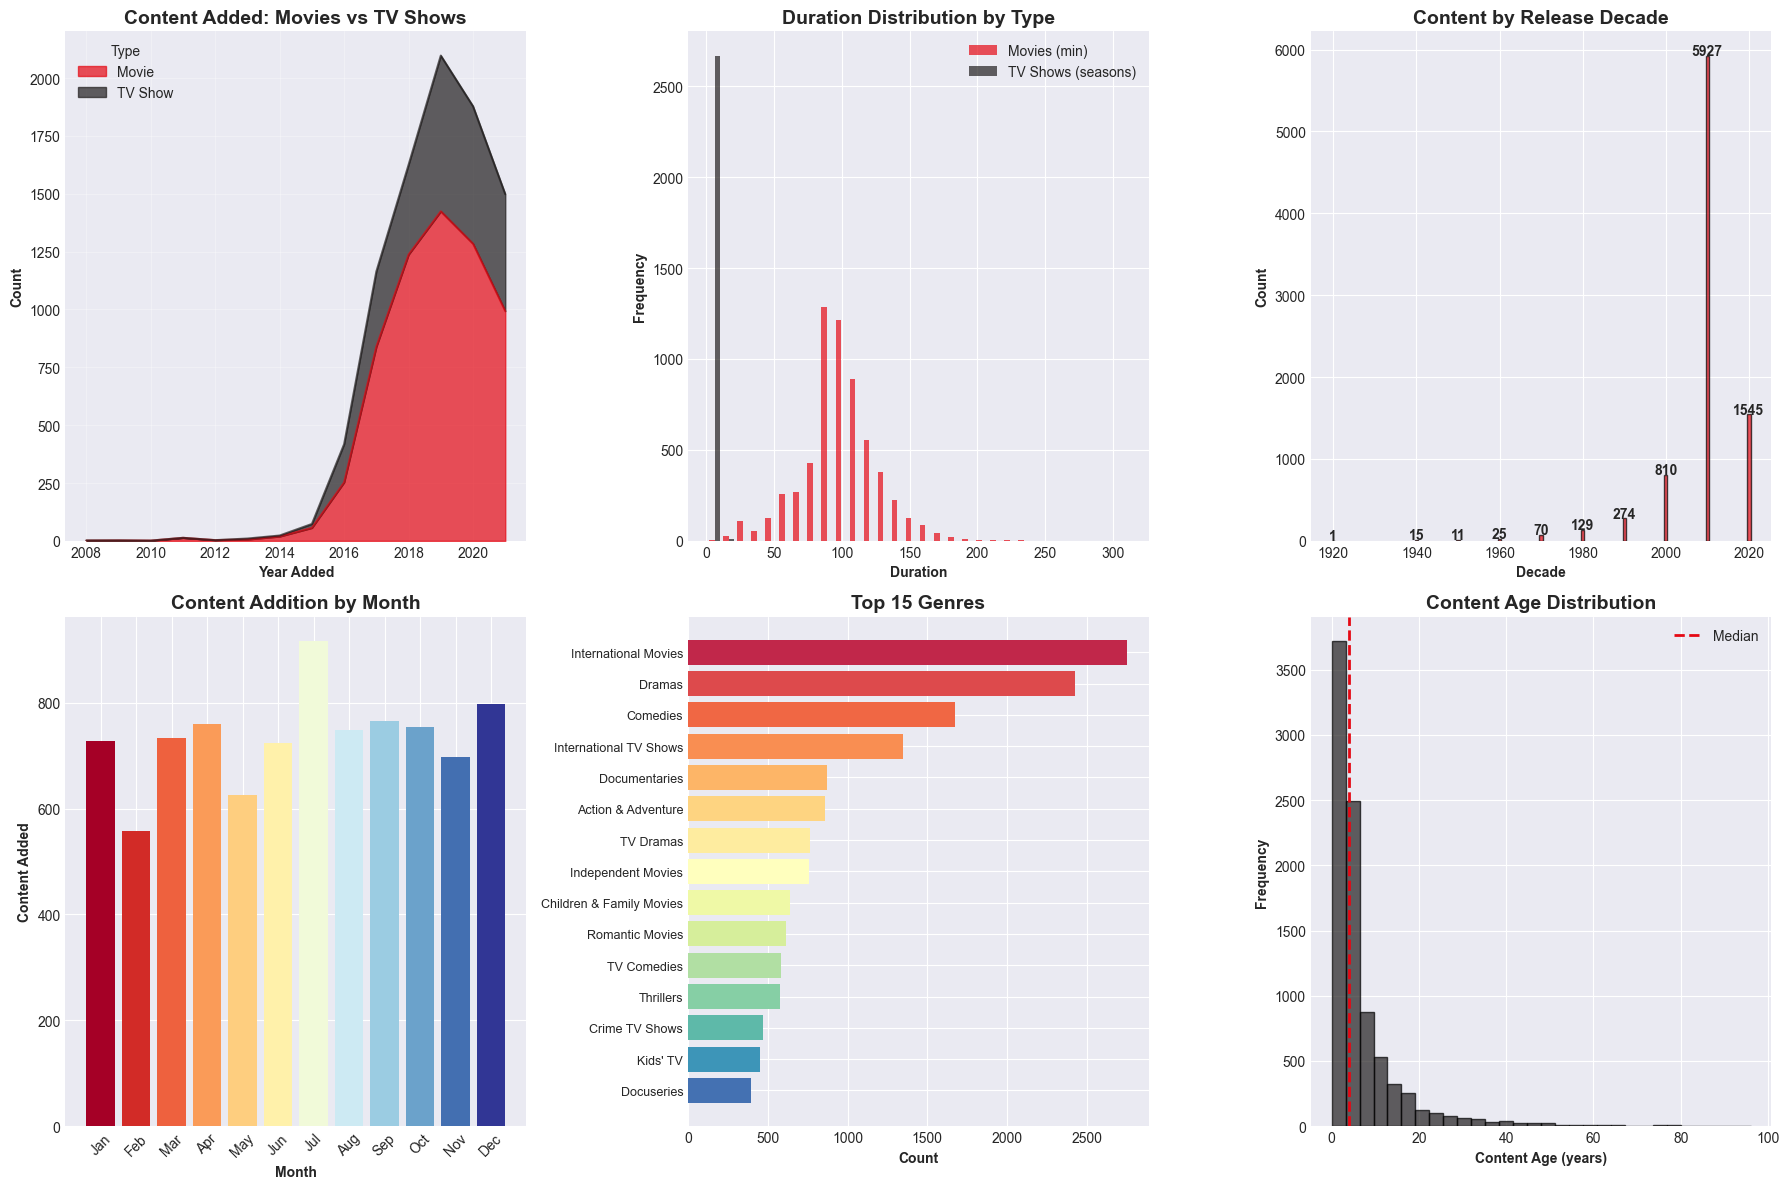

✓ Saved: 06_content_analysis.png


In [22]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

ax = axes[0, 0]
content_by_year = df.groupby(['year_added', 'type']).size().unstack(fill_value=0)
content_by_year.plot(kind='area', stacked=True, ax=ax, color=['#E50914', '#221f1f'], alpha=0.7)
ax.set_xlabel('Year Added', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Content Added: Movies vs TV Shows', fontsize=14, fontweight='bold')
ax.legend(title='Type')
ax.grid(alpha=0.3)

ax = axes[0, 1]
movies_duration = df[df['type'] == 'Movie']['duration_value'].dropna()
tv_duration = df[df['type'] == 'TV Show']['duration_value'].dropna()
ax.hist([movies_duration, tv_duration], bins=30, label=['Movies (min)', 'TV Shows (seasons)'],
        alpha=0.7, color=['#E50914', '#221f1f'])
ax.set_xlabel('Duration', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Duration Distribution by Type', fontsize=14, fontweight='bold')
ax.legend()

ax = axes[0, 2]
decade_counts = df['release_decade'].value_counts().sort_index()
bars = ax.bar(decade_counts.index, decade_counts.values, color='#E50914', alpha=0.7, edgecolor='black')
ax.set_xlabel('Decade', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Content by Release Decade', fontsize=14, fontweight='bold')
for bar, count in zip(bars, decade_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2., count + 10,
            str(count), ha='center', fontweight='bold')

ax = axes[1, 0]
month_counts = df['month_added'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors_months = plt.cm.RdYlBu(np.linspace(0, 1, 12))
bars = ax.bar([month_names[int(m)-1] for m in month_counts.index], month_counts.values,
              color=colors_months)
ax.set_xlabel('Month', fontweight='bold')
ax.set_ylabel('Content Added', fontweight='bold')
ax.set_title('Content Addition by Month', fontsize=14, fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=45)

ax = axes[1, 1]
genre_counts = df['listed_in'].str.split(',').explode().str.strip().value_counts().head(15)
bars = ax.barh(range(len(genre_counts)), genre_counts.values,
               color=sns.color_palette("Spectral", len(genre_counts)))
ax.set_yticks(range(len(genre_counts)))
ax.set_yticklabels(genre_counts.index, fontsize=9)
ax.set_xlabel('Count', fontweight='bold')
ax.set_title('Top 15 Genres', fontsize=14, fontweight='bold')
ax.invert_yaxis()

ax = axes[1, 2]
ax.hist(df['content_age'], bins=30, color='#221f1f', alpha=0.7, edgecolor='black')
ax.set_xlabel('Content Age (years)', fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')
ax.set_title('Content Age Distribution', fontsize=14, fontweight='bold')
ax.axvline(df['content_age'].median(), color='#E50914', linestyle='--', linewidth=2, label='Median')
ax.legend()

plt.tight_layout()
plt.savefig('netflix_visualizations/06_content_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 06_content_analysis.png")

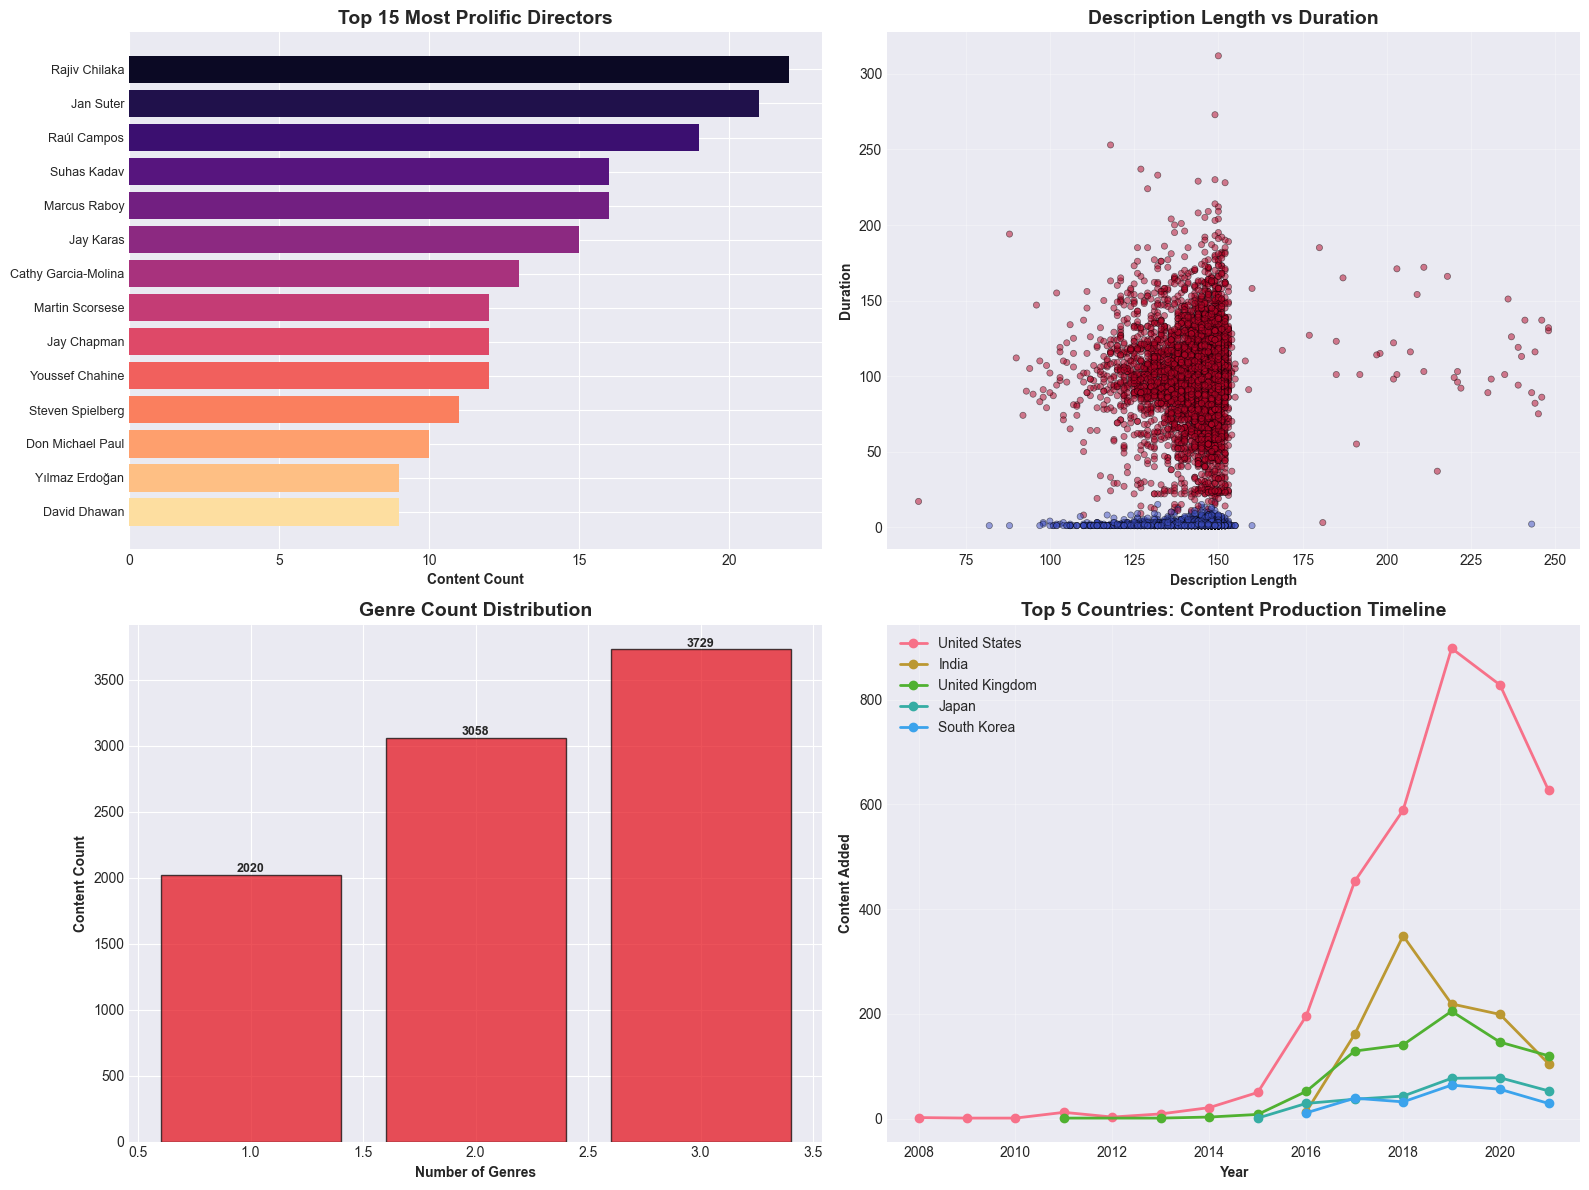

✓ Saved: 07_advanced_analytics.png


In [23]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
directors = df['director'].str.split(',').explode().str.strip().value_counts().head(15)
directors = directors[directors.index != 'Unknown']
bars = ax.barh(range(len(directors)), directors.values,
               color=sns.color_palette("magma", len(directors)))
ax.set_yticks(range(len(directors)))
ax.set_yticklabels(directors.index, fontsize=9)
ax.set_xlabel('Content Count', fontweight='bold')
ax.set_title('Top 15 Most Prolific Directors', fontsize=14, fontweight='bold')
ax.invert_yaxis()

ax = axes[0, 1]
ax.scatter(df['description_length'], df['duration_value'], alpha=0.5, s=20,
           c=df['is_movie'], cmap='coolwarm', edgecolors='black', linewidth=0.5)
ax.set_xlabel('Description Length', fontweight='bold')
ax.set_ylabel('Duration', fontweight='bold')
ax.set_title('Description Length vs Duration', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

ax = axes[1, 0]
genre_count_dist = df['num_genres'].value_counts().sort_index()
bars = ax.bar(genre_count_dist.index, genre_count_dist.values,
              color='#E50914', alpha=0.7, edgecolor='black')
ax.set_xlabel('Number of Genres', fontweight='bold')
ax.set_ylabel('Content Count', fontweight='bold')
ax.set_title('Genre Count Distribution', fontsize=14, fontweight='bold')
for bar, count in zip(bars, genre_count_dist.values):
    ax.text(bar.get_x() + bar.get_width()/2., count + 20,
            str(count), ha='center', fontsize=9, fontweight='bold')


ax = axes[1, 1]
top_countries = ['United States', 'India', 'United Kingdom', 'Japan', 'South Korea']
for country in top_countries:
    country_data = df[df['country'].str.contains(country, na=False, case=False)]
    yearly = country_data.groupby('year_added').size()
    ax.plot(yearly.index, yearly.values, marker='o', label=country, linewidth=2)

ax.set_xlabel('Year', fontweight='bold')
ax.set_ylabel('Content Added', fontweight='bold')
ax.set_title('Top 5 Countries: Content Production Timeline', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('netflix_visualizations/07_advanced_analytics.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 07_advanced_analytics.png")

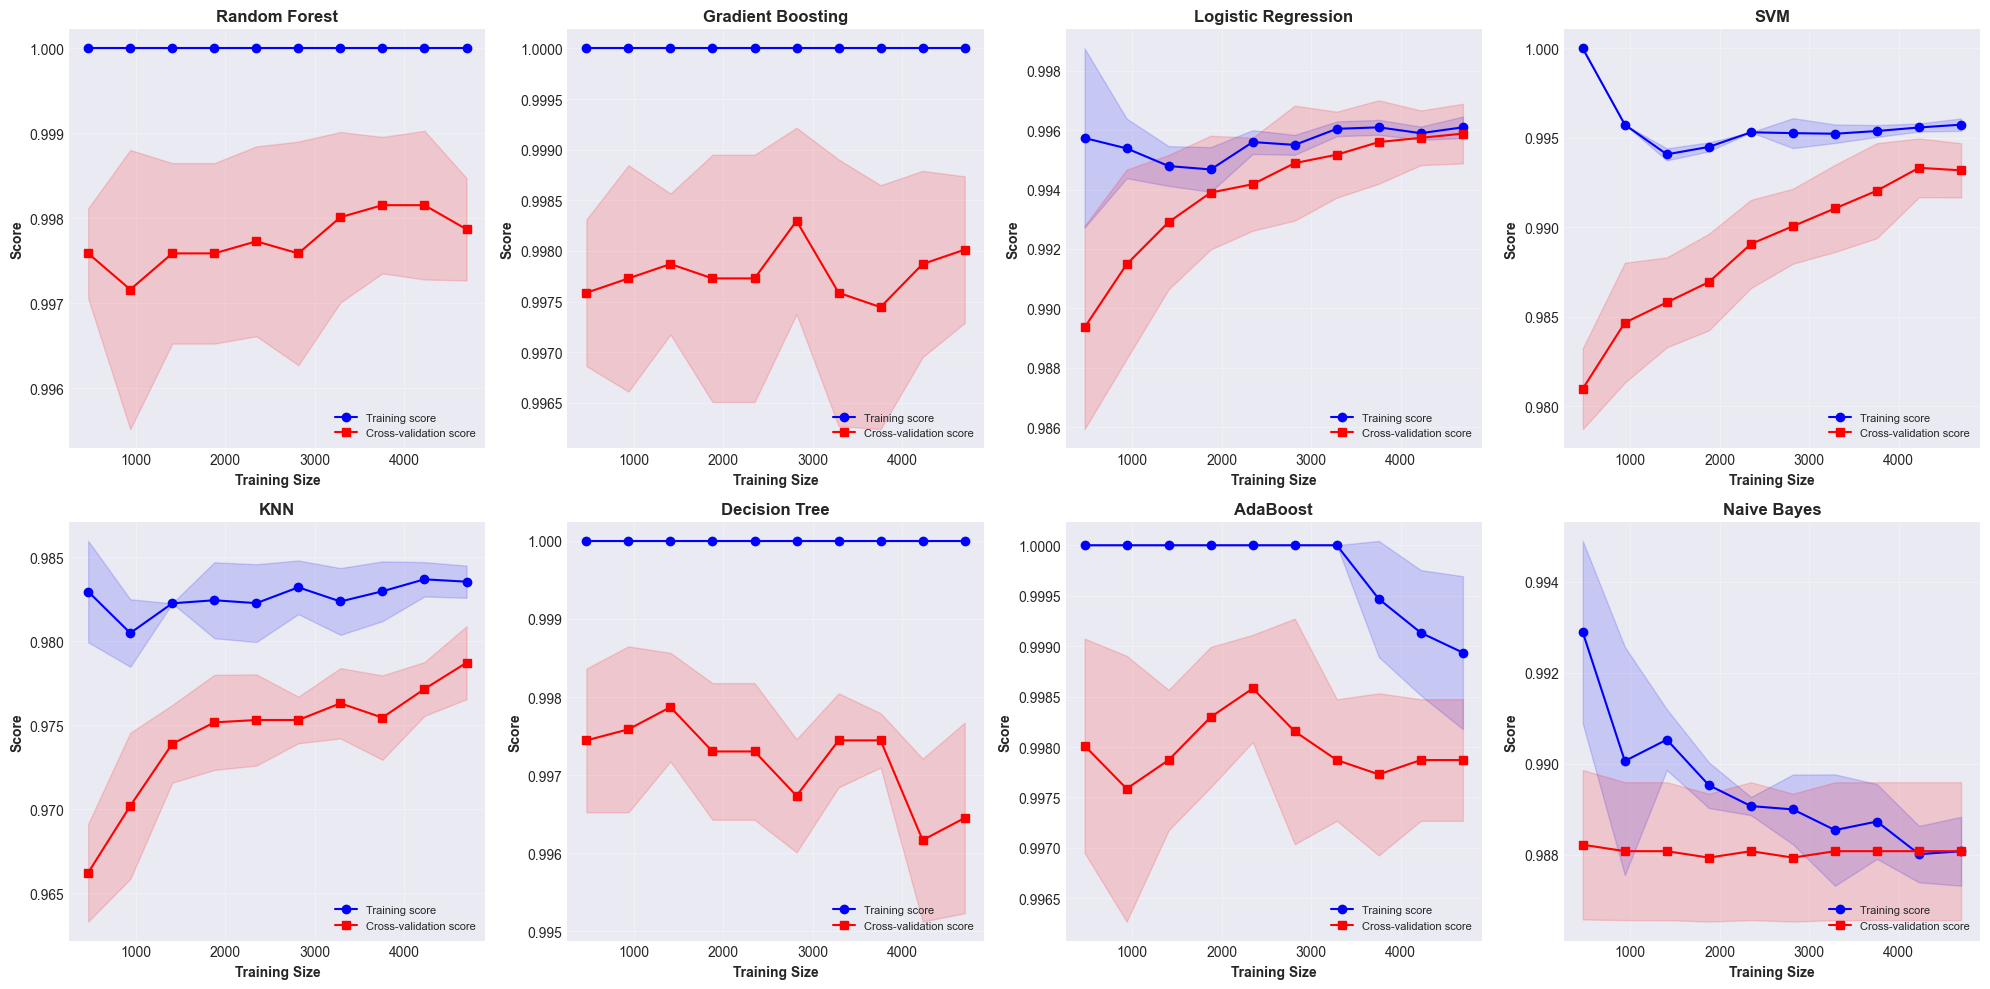

✓ Saved: 08_learning_curves.png


In [24]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    model = result['model']
    
    if name == 'Naive Bayes':
        X_model = X_train + abs(X_train.min().min()) + 1
    else:
        X_model = X_train_scaled
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_model, y_train, cv=3, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    axes[idx].plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
    axes[idx].fill_between(train_sizes, train_mean - train_std, train_mean + train_std,
                            alpha=0.15, color='blue')
    axes[idx].plot(train_sizes, val_mean, label='Cross-validation score', color='red', marker='s')
    axes[idx].fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                            alpha=0.15, color='red')
    axes[idx].set_xlabel('Training Size', fontweight='bold')
    axes[idx].set_ylabel('Score', fontweight='bold')
    axes[idx].set_title(f'{name}', fontweight='bold')
    axes[idx].legend(loc='lower right', fontsize=8)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('netflix_visualizations/08_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("✓ Saved: 08_learning_curves.png")